# In this notebook we will be trying the transformer architecture
This choice is motivated by the fact that the transformer excels at seqtoseq, and is able to capture dependencies spatially and temporally. I hypothesize that this is a good fit for the task since ECOG data is very complex and has dependencies in both time and space.

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import StepLR
import math


ModuleNotFoundError: No module named 'torch'

In [ ]:
import numpy as np

def calculate_vectors(coords, resolution):
    """
    Calculate the average vectors of x and y magnitudes given a resolution.

    Parameters:
    coords (list of tuples): An array of (x, y) coordinates.
    resolution (int): The resolution number.

    Returns:
    list of tuples: An array of vectors of x and y magnitudes.
    """
    if resolution <= 0:
        raise ValueError("Resolution must be a positive integer.")
    
    n = len(coords)
    if resolution > n:
        raise ValueError("Resolution cannot be greater than the length of the coordinates array.")
    
    # Calculate the segment length
    segment_length = n // resolution
    
    vectors = []
    
    for i in range(0, n, segment_length):
        segment = coords[i:i + segment_length]
        if len(segment) < segment_length:
            break
        
        # Calculate the average change in x and y
        delta_x = np.mean([segment[j+1][0] - segment[j][0] for j in range(len(segment) - 1)])
        delta_y = np.mean([segment[j+1][1] - segment[j][1] for j in range(len(segment) - 1)])
        
        vectors.append((delta_x, delta_y))
    
    return vectors

# Example usage:
coords = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 0)]
resolution = 1
vectors = calculate_vectors(coords, resolution)
print(vectors)  # Output: [(0.0, 0.0)]


[(0.0, 0.0)]


## Data Processing

In [ ]:

def vectorize_joystick_readings(x, y, resolution):
     return calculate_vectors(list(zip(x, y)), resolution)

    

In [ ]:
def ica(X, n_components):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    return S_, A_

In [ ]:
def load_jstick_data():
    # Load and preprocess data
    fname = './data/joystick_track.npz'
    alldat = np.load(fname, allow_pickle=True)['dat']
    dat = alldat[0]
    patient_idx = 1
    d = dat[patient_idx]
    # ecog
    ecog_data = d['V'] # Add batch and sequence length dimensions
    ecog_data = PCA(n_components=0.95).fit_transform(ecog_data)
    # magnitudes
    targetX = d['cursorX']
    targetY = d['cursorY']
    print(ecog_data.shape, targetX.shape, targetY.shape)
    resolution = 500
    vectors = np.array(vectorize_joystick_readings(targetX, targetY, resolution))
    print(vectors.shape)
    # match ecog to resolution by grouping, ensuring last sample is not empty
    ecog_data = [ecog_data[i:i+len(vectors)] for i in range(0, len(ecog_data), len(ecog_data)//len(vectors)) if i+len(vectors) <= len(ecog_data)]
    print(len(ecog_data[0]),len(ecog_data[-1]))
    ecog_data = np.array(ecog_data) 
    return ecog_data, vectors

(248640, 28) (248640, 1) (248640, 1)
(500, 2)
500 500


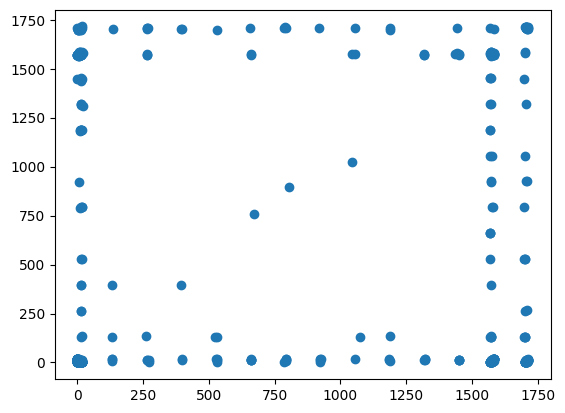

In [ ]:
ecog_data, magnitudes = load_jstick_data()
plt.figure()
plt.scatter([x[0] for x in magnitudes], [x[1] for x in magnitudes])

## 


## Data Augmentation

In [ ]:
# Split data into training and testing
# train test
train_test_split = 0.8
train_size = int(train_test_split * len(ecog_data))
X_train = ecog_data[:train_size]
X_test = ecog_data[train_size:]
y_train = magnitudes[:train_size]
y_test = magnitudes[train_size:]
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(400, 500, 28) (100, 500, 28) 400 100


## Transfromers: robots in disguise

In [ ]:
torch.set_default_device('cuda') if torch.cuda.is_available() else torch.set_default_device('cpu')

In [ ]:
# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class ECoGTransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(ECoGTransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(model_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # (batch_size, sequence_length, model_dim) -> (sequence_length, batch_size, model_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # (sequence_length, batch_size, model_dim) -> (batch_size, sequence_length, model_dim)
        x = self.fc(x[:, -1, :])  # Use the output of the last sequence element
        return x
# Example hyperparameters
input_dim = ecog_data.shape[-1]
model_dim = 64
num_heads = 8
num_layers = 4
output_dim = 2 

model = ECoGTransformerEncoder(input_dim, model_dim, num_heads, num_layers, output_dim)


c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

num_epochs = 1000
print(X_train.shape, y_train.shape)
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")    

torch.Size([400, 500, 28]) torch.Size([400, 2])


c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 0, Loss: 1021215.8125


KeyboardInterrupt: 